# Single Cell Gene Expression Prediction using H&E Images based on Spatial Transcriptomics

**Author:** C. H. Huang

* This tutorial demonstrates how to QC and work with spatial transcriptomics data within ST-AnD.
* We focus on 10x Genomics [Visium](https://www.10xgenomics.com/spatial-transcriptomics/) data.

**Abstract** *In situ* RNA capturing represents an excellent opportunity for bridging transcriptomic data to a spatial domain, making it possible to map the gene expression to the corresponding anatomical structure. As a result, scientists can better understand the transcriptional heterogeneity with spatially re-solved, anatomical, and pathophysiological contexts. However, high throughput sequencing technologies paired with histological images suffer from lower resolution mapping between transcriptome and imaging data. Here, we present Spatial Transcriptome Auto-encoder & Deconvolution (ST-AnD), a scalable deep generative model for predicting gene expression at cellular or nuclei level based on H&E imaging and in situ RNA capturing, thus allowing a better understanding of the tissue microenvironment of a disease.

In [1]:
import os
import glob
from tqdm import tqdm
import configparser
import scanpy as sc
import pandas as pd
import numpy as np
from PIL import Image
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard, CSVLogger, ModelCheckpoint
from VQVAE import VQVAEDataGenerator, VQVAETrainer
from STAnD import STAnD, STAnDDataGenerator, MILPoolingLayer, DenormalizationLayer

In [2]:
tf.executing_eagerly()
gpu_device_list = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpu_device_list))
for gpu_device in gpu_device_list: tf.config.experimental.set_memory_growth(gpu_device, True)

Num GPUs Available:  2


2022-03-16 20:35:24.018426: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 20:35:24.018687: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 20:35:24.048275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 20:35:24.048423: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 20:35:24.048545: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

First, we obtain the dataset from Visium website. *E.g.*,

In [3]:
!mkdir ./data/Adult_Mouse_Brain_FFPE
# Input Files

!test ! -e ./data/Adult_Mouse_Brain_FFPE/Visium_FFPE_Mouse_Brain_fastqs.tar && cd ./data/Adult_Mouse_Brain_FFPE && curl -O https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Mouse_Brain/Visium_FFPE_Mouse_Brain_fastqs.tar
!test ! -e ./data/Adult_Mouse_Brain_FFPE/Visium_FFPE_Mouse_Brain_image.jpg && cd ./data/Adult_Mouse_Brain_FFPE && curl -O https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Mouse_Brain/Visium_FFPE_Mouse_Brain_image.jpg
!test ! -e ./data/Adult_Mouse_Brain_FFPE/Visium_FFPE_Mouse_Brain_probe_set.csv && cd ./data/Adult_Mouse_Brain_FFPE && curl -O https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Mouse_Brain/Visium_FFPE_Mouse_Brain_probe_set.csv

# Output Files
!test ! -e ./data/Adult_Mouse_Brain_FFPE/Visium_FFPE_Mouse_Brain_possorted_genome_bam.bam && cd ./data/Adult_Mouse_Brain_FFPE && curl -O https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Mouse_Brain/Visium_FFPE_Mouse_Brain_possorted_genome_bam.bam
!test ! -e ./data/Adult_Mouse_Brain_FFPE/Visium_FFPE_Mouse_Brain_possorted_genome_bam.bam.bai && cd ./data/Adult_Mouse_Brain_FFPE && curl -O https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Mouse_Brain/Visium_FFPE_Mouse_Brain_possorted_genome_bam.bam.bai
!test ! -e ./data/Adult_Mouse_Brain_FFPE/Visium_FFPE_Mouse_Brain_molecule_info.h5 && cd ./data/Adult_Mouse_Brain_FFPE && curl -O https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Mouse_Brain/Visium_FFPE_Mouse_Brain_molecule_info.h5
!test ! -e ./data/Adult_Mouse_Brain_FFPE/Visium_FFPE_Mouse_Brain_filtered_feature_bc_matrix.h5 && cd ./data/Adult_Mouse_Brain_FFPE && curl -O https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Mouse_Brain/Visium_FFPE_Mouse_Brain_filtered_feature_bc_matrix.h5
!test ! -e ./data/Adult_Mouse_Brain_FFPE/Visium_FFPE_Mouse_Brain_filtered_feature_bc_matrix.tar.gz && cd ./data/Adult_Mouse_Brain_FFPE && curl -O https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Mouse_Brain/Visium_FFPE_Mouse_Brain_filtered_feature_bc_matrix.tar.gz
!test ! -e ./data/Adult_Mouse_Brain_FFPE/Visium_FFPE_Mouse_Brain_raw_feature_bc_matrix.h5 && cd ./data/Adult_Mouse_Brain_FFPE && curl -O https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Mouse_Brain/Visium_FFPE_Mouse_Brain_raw_feature_bc_matrix.h5
!test ! -e ./data/Adult_Mouse_Brain_FFPE/Visium_FFPE_Mouse_Brain_raw_feature_bc_matrix.tar.gz && cd ./data/Adult_Mouse_Brain_FFPE && curl -O https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Mouse_Brain/Visium_FFPE_Mouse_Brain_raw_feature_bc_matrix.tar.gz
!test ! -e ./data/Adult_Mouse_Brain_FFPE/Visium_FFPE_Mouse_Brain_analysis.tar.gz && cd ./data/Adult_Mouse_Brain_FFPE && curl -O https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Mouse_Brain/Visium_FFPE_Mouse_Brain_analysis.tar.gz
!test ! -e ./data/Adult_Mouse_Brain_FFPE/Visium_FFPE_Mouse_Brain_spatial.tar.gz && cd ./data/Adult_Mouse_Brain_FFPE && curl -O https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Mouse_Brain/Visium_FFPE_Mouse_Brain_spatial.tar.gz
!test ! -e ./data/Adult_Mouse_Brain_FFPE/Visium_FFPE_Mouse_Brain_spatial_enrichment.csv && cd ./data/Adult_Mouse_Brain_FFPE && curl -O https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Mouse_Brain/Visium_FFPE_Mouse_Brain_spatial_enrichment.csv
!test ! -e ./data/Adult_Mouse_Brain_FFPE/Visium_FFPE_Mouse_Brain_metrics_summary.csv && cd ./data/Adult_Mouse_Brain_FFPE && curl -O https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Mouse_Brain/Visium_FFPE_Mouse_Brain_metrics_summary.csv
!test ! -e ./data/Adult_Mouse_Brain_FFPE/Visium_FFPE_Mouse_Brain_web_summary.html && cd ./data/Adult_Mouse_Brain_FFPE && curl -O https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Mouse_Brain/Visium_FFPE_Mouse_Brain_web_summary.html
!test ! -e ./data/Adult_Mouse_Brain_FFPE/Visium_FFPE_Mouse_Brain_cloupe.cloupe && cd ./data/Adult_Mouse_Brain_FFPE && curl -O https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Mouse_Brain/Visium_FFPE_Mouse_Brain_cloupe.cloupe

mkdir: cannot create directory ‘./data/Adult_Mouse_Brain_FFPE’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4154M  100 4154M    0     0  5867k      0  0:12:04  0:12:04 --:--:-- 6269k  0:00:07  0:14:48 6018k0:11:28  0:02:05  0:09:23 6468k 0:11:58  0:02:54  0:09:04 4809k12:11  0:04:31  0:07:40 4982k:06  0:05:34  0:06:32 5891k  0:12:07  0:07:08  0:04:59 4882k07  0:10:29  0:01:38 6121k12:05  0:10:58  0:01:07 6144k07  0:11:25  0:00:42 6412k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  283M  100  283M    0     0  6534k      0  0:00:44  0:00:44 --:--:-- 6358k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2257k  100 2257k    0     0  25

Then, we assign variables of the data folder so that the program can get access to them. Note that `spatial_data_filename` represents the `filtered_feature_bc_matrix.h5` file and `spatial_image_folder` is the location of nuclei images for each spot.

In [4]:
spatial_data_filename = "./data/Adult_Mouse_Brain_FFPE/Visium_FFPE_Mouse_Brain_filtered_feature_bc_matrix.h5"
spatial_image_folder = "./data/Adult_Mouse_Brain_FFPE/images"

## Reading the data

We use [sc.read_visium()](https://scanpy.readthedocs.io/en/latest/api/scanpy.read_visium.html) function to import the downloaded Visium dataset.

In [5]:
adata_spatial = sc.read_visium(os.path.os.path.dirname(spatial_data_filename), count_file=os.path.os.path.basename(spatial_data_filename))
adata_spatial.var_names_make_unique()
adata_spatial.var["mt"] = adata_spatial.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata_spatial, qc_vars=["mt"], inplace=True)

/opt/anaconda3/envs/p/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## QC and preprocessing

We perform some basic filtering of spots based on total counts and expressed genes

/opt/anaconda3/envs/p/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='n_genes_by_counts'>

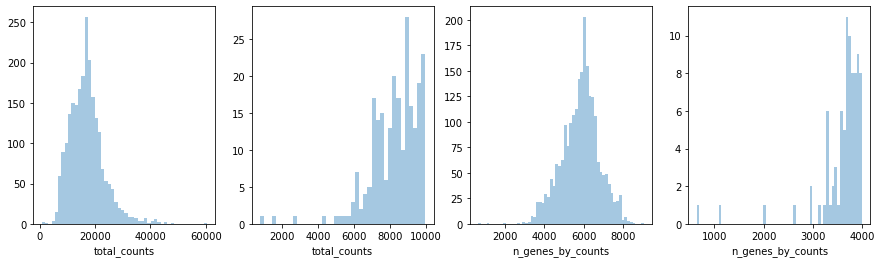

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata_spatial.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata_spatial.obs["total_counts"][adata_spatial.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata_spatial.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata_spatial.obs["n_genes_by_counts"][adata_spatial.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])

In [7]:
sc.pp.filter_cells(adata_spatial, min_counts=5000)
sc.pp.filter_cells(adata_spatial, max_counts=35000)
adata_spatial = adata_spatial[adata_spatial.obs["pct_counts_mt"] < 20]
print(f"#cells after MT filter: {adata_spatial.n_obs}")
sc.pp.filter_genes(adata_spatial, min_cells=10)

#cells after MT filter: 2230


/opt/anaconda3/envs/p/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


We proceed to normalize Visium counts data with the built-in `normalize_total` method from Scanpy, and detect highly-variable genes (for later). Note that there are alternatives for normalization (see discussion in [[Luecken19](https://www.embopress.org/doi/full/10.15252/msb.20188746)], and more recent alternatives such as [SCTransform](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1874-1) or [GLM-PCA](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1861-6)).

In [8]:
sc.pp.normalize_total(adata_spatial, inplace=True)
sc.pp.log1p(adata_spatial)
sc.pp.highly_variable_genes(adata_spatial, flavor="seurat", n_top_genes=2000)

### Manifold embedding and clustering based on transcriptional similarity

To embed and cluster the manifold encoded by transcriptional similarity, we proceed as in the standard clustering tutorial.

In [9]:
sc.pp.pca(adata_spatial)
sc.pp.neighbors(adata_spatial)
sc.tl.umap(adata_spatial)
sc.tl.leiden(adata_spatial, key_added="clusters")

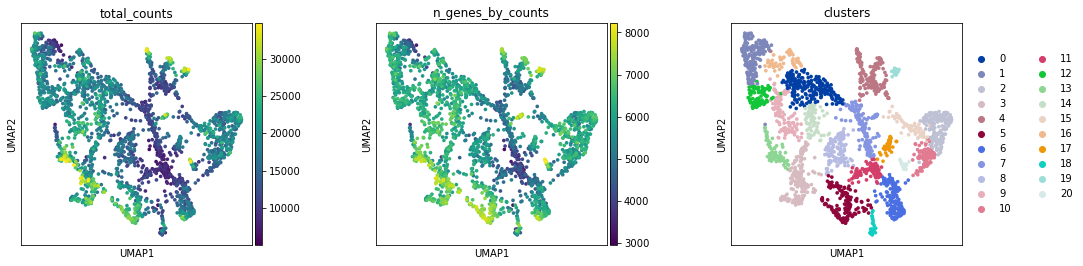

In [10]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata_spatial, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

### Visualization in spatial coordinates

Let us now take a look at how `total_counts` and `n_genes_by_counts` behave in spatial coordinates. We will overlay the circular spots on top of the Hematoxylin and eosin stain (H&E) image provided, using the function [sc.pl.spatial](https://scanpy.readthedocs.io/en/latest/api/scanpy.pl.spatial.html).

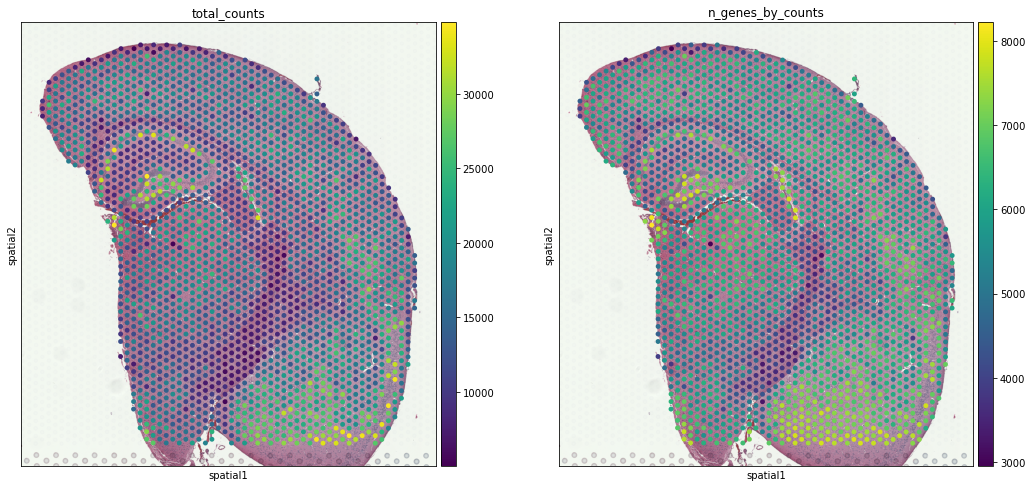

In [11]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata_spatial, img_key="hires", color=["total_counts", "n_genes_by_counts"])

The function [sc.pl.spatial](https://scanpy.readthedocs.io/en/latest/api/scanpy.pl.spatial.html) accepts 4 additional parameters:

* `img_key`: key where the img is stored in the `adata.uns` element
* `crop_coord`: coordinates to use for cropping (left, right, top, bottom)
* `alpha_img`: alpha value for the transcparency of the image
* `bw`: flag to convert the image into gray scale  

Furthermore, in [sc.pl.spatial](https://scanpy.readthedocs.io/en/latest/api/scanpy.pl.spatial.html), the `size` parameter changes its behaviour: it becomes a scaling factor for the spot sizes.

Before, we performed clustering in gene expression space, and visualized the results with UMAP. By visualizing clustered samples in spatial dimensions, we can gain insights into tissue organization and, potentially, into inter-cellular communication.

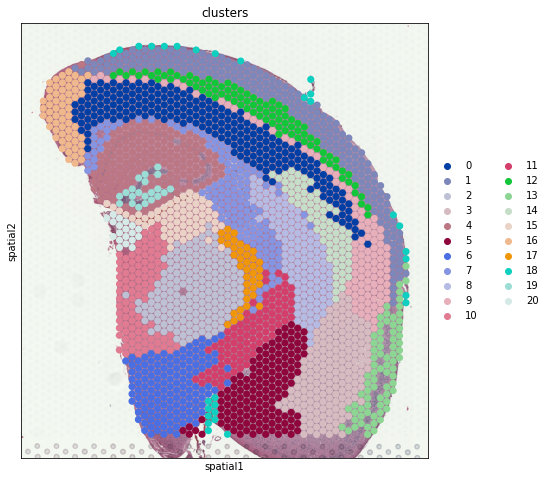

In [12]:
sc.pl.spatial(adata_spatial, img_key="hires", color="clusters", size=1.5)

### Cluster marker genes

Let us further inspect cluster 5, which occurs in small groups of spots across the image.

Compute marker genes and plot a heatmap with expression levels of its top 10 marker genes across clusters.

categories: 0, 1, 2, etc.
var_group_labels: 5


/opt/anaconda3/envs/p/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/anaconda3/envs/p/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/anaconda3/envs/p/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmente

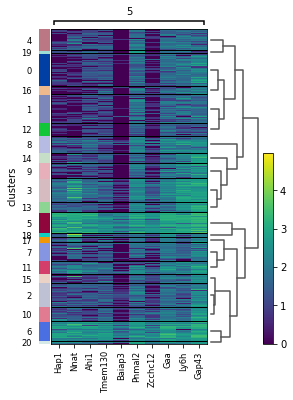

In [13]:
sc.tl.rank_genes_groups(adata_spatial, "clusters", method="t-test")
sc.pl.rank_genes_groups_heatmap(adata_spatial, groups="5", n_genes=10, groupby="clusters")

We see that *CR2* recapitulates the spatial structure.

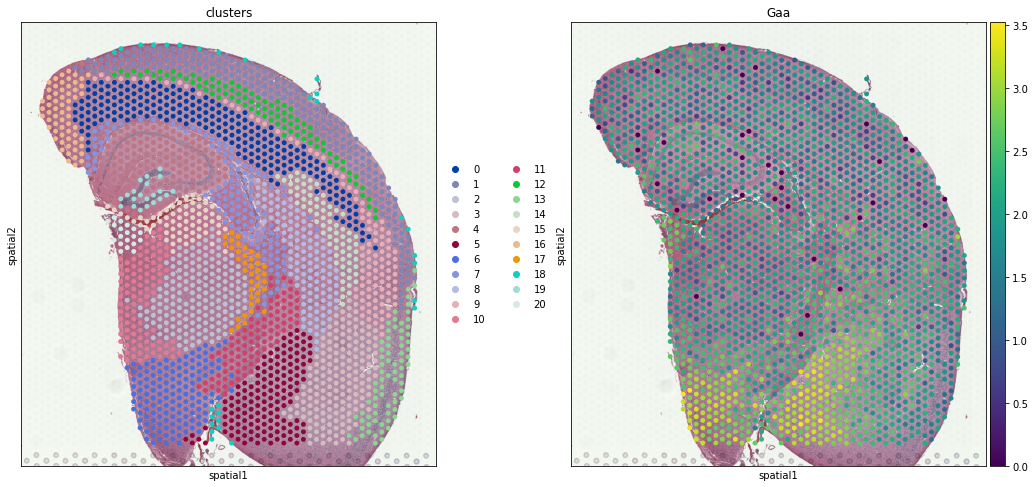

In [14]:
sc.pl.spatial(adata_spatial, img_key="hires", color=["clusters", "Gaa"])

## Preparing and Training ST-AnD Model

ST-AnD model includes two parts: the first part is the ST-Image-Encoder, which aims to convert the feature of a nuclei image to a data point in a lower-dimensional data space; the second part is ST-Genomic-Decoder, which bridges the above-mentioned latent data space to the corresponding spot gene expression profile. As a result, it can estimate the probability of gene expression data of the spot. In this way, we can estimate the gene expression distribution of the highest probability density based on the cell image features.

### ST-Image-Encoder

The purpose of ST-Encoder is converting nuclei image set into a numerical feature set. The input include a folder containing the nuclei images in each spot. *E.g.*, 

    images
    .
    ├── AAACAGAGCGACTCCT-1
    │   ├── 0.png
    │   ├── 1.png
    │   ├── 2.png    
    │   └── 3.png
    ├── AAACCCGAACGAAATC-1
    │   ├── 0.png
    │   ├── 1.png
    │   ├── 2.png
    │   ├── 3.png
    │   ├── 4.png
    │   ├── 5.png
    │   ├── 6.png
    │   ├── 7.png
    │   ├── 8.png
    │   └── 8.png
    ├── AAACCGGGTAGGTACC-1
    .
    .
    
The imageset has to be provided.

Data preparation for VQ-VAE. The class VQVAEDataGenerator is an implementation of keras.utils.Sequence which generates the data sequence for the following training process. The parameters include:
> * image_folder: pointing to the above mentioned imageset folder.                 
> * batch_size: the batch size used for training VQ-VAE model.
> * augmentation: **True** for expanding the imageset by rotation and flipping. 
> * random_seed, k and m_list: parameters for $k$-cross validation. Here we can use the default value as we do not separate the dataset training VQ-VAE. 

In [15]:
vqvae_batch_size = 128
vqvae_x_train = VQVAEDataGenerator(image_folder=spatial_image_folder, 
                                   batch_size = vqvae_batch_size, 
                                   random_seed=1234, 
                                   k=10, m_list=[0,1,2,3,4,5,6,7,8,9])   

The training process for VQ-VAE. The parameters include: 
> * data_variance: the variance of the imageset, which can be obtained from VQVAEDataGenerator.
> * image_size: the width/height of the images in the above mentioned imageset.
> * latent_dim and num_embeddings: the variable of VQ-VAE embeddings for generating the image features. For the details please rewfer to the VQ-VAE paper.

In [16]:
sampling_size = 28
latent_dim = 16
num_embeddings = 1024
image_pixel_size = 0.5

data_variance = vqvae_x_train.get_variance()

vqvae_trainer = VQVAETrainer(data_variance, 
                             image_size=sampling_size, 
                             latent_dim=latent_dim, 
                             num_embeddings=num_embeddings)

vqvae_trainer.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
vqvae_trainer.vqvae.summary()

Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 encoder (Functional)        (None, 7, 7, 16)          20432     
                                                                 
 vector_quantizer (VectorQua  (None, 7, 7, 16)         16384     
 ntizer)                                                         
                                                                 
 decoder (Functional)        (None, 28, 28, 3)         28611     
                                                                 
Total params: 65,427
Trainable params: 65,427
Non-trainable params: 0
_________________________________________________________________


2022-03-16 21:06:02.211393: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-16 21:06:02.349068: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 21:06:02.349331: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 21:06:02.349475: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

In [17]:
vqvae_trainer_tensorboard = TensorBoard(log_dir='encoder_tensorboard_logs',
                                        histogram_freq=0)

vqvae_model_checkpoint = ModelCheckpoint(filepath='encoder-{epoch:04d}-{loss:.4f}.model.h5',                                         
                                         monitor='loss',
                                         verbose=1,
                                         mode='min',
                                         save_best_only=True,
                                         save_weights_only=True)

vqvae_csvlogger = CSVLogger('encoder_logs.csv', append=True, separator=',')

callbacks = [
    # vqvae_trainer_tensorboard,
    # vqvae_model_checkpoint,
    # vqvae_csvlogger,
]

Next, we train the VQ-VAE model. The targeting encoder file name is defined as:

In [18]:
encoder_model_filename = 'encoder-final.model.h5'

Please rename or remove the targeting model file when retraining the decoder model.

In [19]:
if not os.path.exists(encoder_model_filename):
    vqvae_trainer.fit(vqvae_x_train, 
                      epochs=100, 
                      batch_size=vqvae_batch_size, 
                      shuffle=True,
                      callbacks=callbacks)

    vqvae_trainer.vqvae.save_weights(encoder_model_filename)
else:
    vqvae_trainer.vqvae.load_weights(encoder_model_filename)

The model file can be found in the folder.

### ST-Genomic-Decoder

We prepare the dataset for training the ST-Decoder model. We splited the spots into 90% for training and 10% for test. 
> * sptx_data: Visium dataset in AnnData format.
> * gene_list: a list of the chosen genes.
> * vqvae_encoder and vqvae_quantizer: VQ-VAE encoder and quantizer for encoding the input nuclei image.
> * batch_size: Batch size for training. Default: 8
> * random_seed: the seed for generating the pseudo random number for the following image shuffling. Use the same random_seed in the same experiments. 
> * k and m_list: partitioning the dataset for *k*-cross-validation. *k* represents the number of partitions, and m_list represents the chosen partitions which are being included in the specific subset. 

In [20]:
stand_batch_size = 8
gene_list = adata_spatial.var_names.tolist()
decoder_input_dim = int(np.prod(vqvae_trainer.vqvae.get_layer('encoder').predict(vqvae_x_train[0]).shape[1:]))
vqvae_encoder = vqvae_trainer.vqvae.get_layer("encoder")
vqvae_quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

stand_x_train = STAnDDataGenerator(image_folder='data/Adult_Mouse_Brain_FFPE/images', 
                                   sptx_data=adata_spatial, 
                                   gene_list=gene_list, 
                                   vqvae_encoder=vqvae_encoder, 
                                   vqvae_quantizer=vqvae_quantizer, 
                                   batch_size = stand_batch_size, 
                                   random_seed=1234, 
                                   k=10, 
                                   m_list=[0,1,2,3,4,5,6,7,8])

stand_x_test = STAnDDataGenerator(image_folder='data/Adult_Mouse_Brain_FFPE/images', 
                                  sptx_data=adata_spatial, 
                                  gene_list=gene_list, 
                                  vqvae_encoder=vqvae_encoder, 
                                  vqvae_quantizer=vqvae_quantizer, 
                                  batch_size = stand_batch_size, 
                                  random_seed=1234, 
                                  k=10, 
                                  m_list=[9])

2022-03-16 21:06:03.560253: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-03-16 21:06:03.864505: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Define the ST-Decoder model.
> * input_dim: The timension of the image feature vector.
> * output_dim: The number of the chosen genes.
> * fcn_dropout_rate: The dropout rate for the FCN which is used for mapping the given nuclei image feature features to gene expression domain.
> * beta: the inverse of the maximal nuclei number under a spot. E.g., 1/20.
> * batch_size: batch size for training. Default: 8.
> * pooling: *True* for mapping the gene expresion for spots (using the nuclei images under the same spot). Otherwise, mapping the gene exppression for each nuclei image.
> * pooling_type: including noisy-and, noisy-or, gm, isr, etc. Default: noisy-and.
> * pooling_gamma: gamma parameter for multiple instance learning. 

In [21]:
enable_coexpr = False
decoder_hidden_layers = [len(gene_list),]
pooling_type = 'noisy-and'
pooling_beta = 0.05
pooling_gamma = 5.0

stand = STAnD(input_dim = decoder_input_dim, 
              output_dim = len(gene_list),               
              decoder_hidden_layers = [len(gene_list),], 
              fcn_dropout_rate = 0.2,
              # fcn_batchnormalization = False,
              enable_coexpr=enable_coexpr, 
              beta=pooling_beta, 
              batch_size=stand_batch_size, 
              pooling = True, 
              pooling_type='noisy-and', 
              pooling_gamma=pooling_gamma,
              name='stand')

stand.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
stand.summary()

Model: "st_an_d_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 784)]             0         
                                                                 
 cell_fcn_layer_0 (Dense)    (None, 14605)             11464925  
                                                                 
 cell_fcn_dropout_0 (Dropout  (None, 14605)            0         
 )                                                               
                                                                 
 cell_fcn_activation_0 (Acti  (None, 14605)            0         
 vation)                                                         
                                                                 
 cell_fcn_layer_output (Dens  (None, 14605)            213320630 
 e)                                                              
                                                         

In [22]:
stand_tensorboard = TensorBoard(log_dir='decoder_tensorboard_logs', 
                                histogram_freq=1, 
                                write_images=True)

stand_checkpoint = ModelCheckpoint(filepath='decoder-{epoch:04d}-{val_loss:.4f}.model.h5' ,
                                   monitor='val_loss',
                                   verbose=1,
                                   mode='min',
                                   save_best_only=True,
                                   save_weights_only=True)

stand_csvlogger = CSVLogger('decoder_logs.csv', 
                            append=True, 
                            separator=',')

callbacks = [
    # stand_tensorboard,
    # stand_checkpoint,
    # stand_csvlogger,
]

Train the ST-Decoder machine learning model. The targeting decoder file name is defined as:

In [23]:
decoder_model_filename = 'decoder-final.model.h5'

Please rename or remove the targeting model file when retraining the decoder model.

In [24]:
if not os.path.exists(decoder_model_filename):
    stand.fit(stand_x_train, 
              epochs=100, 
              shuffle=True,
              callbacks=callbacks,
              validation_data=stand_x_test)
    stand.save_weights(decoder_model_filename)
else:
    stand.load_weights(decoder_model_filename)

Once the training process is finished, the model file can be found in the folder.

In the next, we will evaluate the performance using Spearman's algoreithm to evaluate the correlation between predicted outpout and the groundtruth using test dataset.

In [25]:
y_pred_list = []
y_test_list = []

stand.set_pooling(True)

for i in tqdm(range(len(stand_x_test))):
    for b in range(len(stand_x_test[i][0])):
        reduced_sum = np.sum(np.abs(stand_x_test[i][0][b]),axis=1)
        zero = np.zeros(shape=(1,1), dtype=np.float32)
        nonzero_mask = np.not_equal(reduced_sum, zero)
        z = stand_x_test[i][0][b][nonzero_mask[0],]
        # y_pred = stand.predict(z, batch_size=len(z)
        y_pred = stand(z)
        y_test = stand_x_test[i][1][b][0]
        y_pred_list.append(y_pred[0])
        y_test_list.append(y_test)

y_pred_list = np.stack(y_pred_list, axis=0).transpose()
y_test_list = np.stack(y_test_list, axis=0).transpose()

abundance_list = np.log(np.mean(np.exp(y_pred_list)-1.0, axis=1)+1.0).tolist()

r_list = []
p_list = []

for i in range(len(gene_list)):
    r, p = spearmanr(y_test_list[i], y_pred_list[i])
    r_list.append(r)
    p_list.append(p)

r_list = np.array(r_list)
p_list = np.array(p_list)



100%|███████████████████████████████████████████| 27/27 [02:36<00:00,  5.81s/it]
/opt/anaconda3/envs/p/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Due to the fact that some genes can be unavailable in the test set, Spearman's algorithm can be `nan`. We replace them using 0 for rho list, and 1 for p-value list.

In [26]:
r_list[np.isnan(r_list)] = 0
p_list[np.isnan(p_list)] = 1

Mean Spearman's coefficient of available genes (r!=0): 0.05355128240601825
Ratio of available genes (Spearman's coefficient > 0): 0.3637795275590551


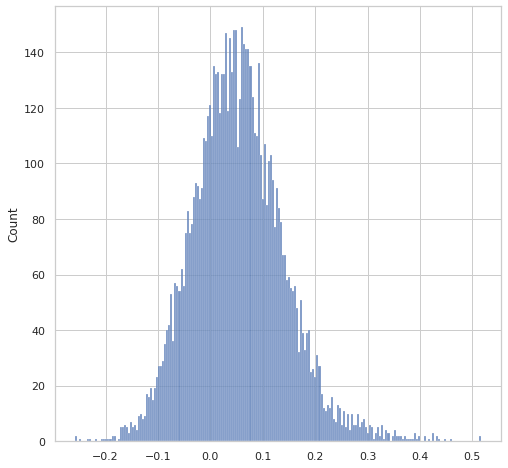

In [27]:
sns.set_theme(style="whitegrid")
ax = sns.histplot(r_list[np.where(r_list!=0)], bins=200)
print("Mean Spearman's coefficient of available genes (r!=0):", r_list[np.where(r_list!=0)].mean())
print("Ratio of available genes (Spearman's coefficient > 0):", (r_list>0).sum()/len(r_list))

We plot the histogram of the p-values of all available genes. 

Number of genes that p-value<1: 7281 , ratio: 0.4985279014036289
Number of genes that p-value<.05: 1261 , ratio: 0.08634029441971927
Number of genes that p-value<.001: 252 , ratio: 0.017254364943512495


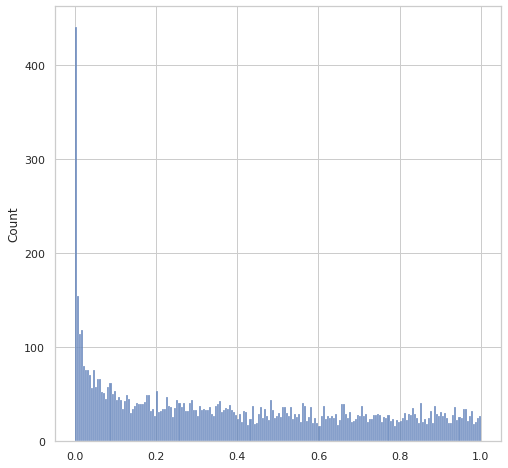

In [28]:
sns.set_theme(style="whitegrid")
ax = sns.histplot(p_list[np.where(p_list!=1)], bins=200)
print("Number of genes that p-value<1:", (p_list<1).sum(), ", ratio:", (p_list<1).sum()/len(p_list))
print("Number of genes that p-value<.05:", (p_list<0.05).sum(), ", ratio:", (p_list<0.05).sum()/len(p_list))
print("Number of genes that p-value<.001:", (p_list<0.001).sum(), ", ratio:", (p_list<0.001).sum()/len(p_list))

We can then sort the genes by the obtained Spearman's coefficients, so that we can identify the importance of each gene.

In [31]:
ranked = np.argsort(r_list)
ordered_indices = ranked[::-1]

ordered_gene_list = np.array(gene_list)[np.array(ordered_indices)].tolist()
ordered_r_list = np.array(r_list)[np.array(ordered_indices)].tolist()
ordered_p_list = np.array(p_list)[np.array(ordered_indices)].tolist()

In [65]:
chosen_gene_df = pd.DataFrame({"Genes": ordered_gene_list, "Spearman's Coeff.": ordered_r_list, "p-value": ordered_p_list}).head(n=(p_list<0.001).sum())
print("genes that p-value<.001")
chosen_gene_df

genes that p-value<.001


,Genes,Spearman's Coeff.,p-value
0,Satb2,0.516029,4.261470e-16
1,Mmp17,0.512410,7.372768e-16
2,Slc8a2,0.459179,1.157087e-12
3,Tmem178,0.446702,5.440964e-12
4,Ier5,0.436558,1.830047e-11
...,...,...,...
247,Lbh,0.222050,1.017511e-03
248,Fut9,0.221871,1.027374e-03
249,Sqstm1,0.221796,1.031534e-03
250,Pitpnm2,0.221774,1.032780e-03


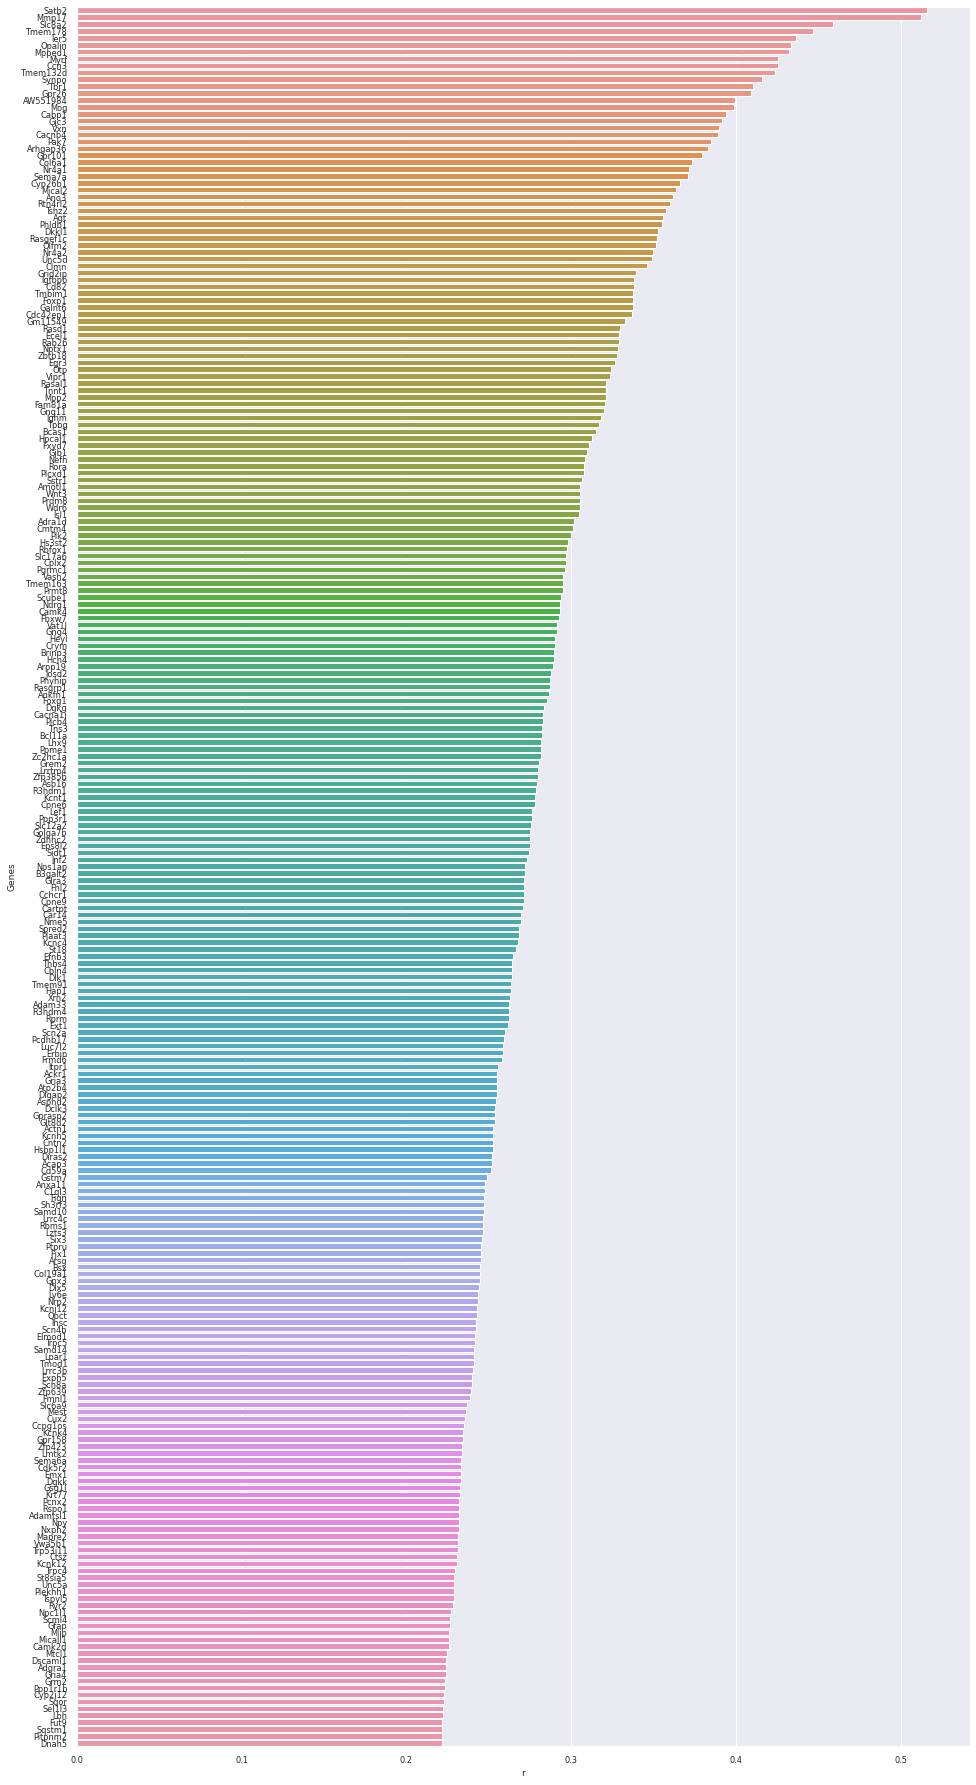

In [66]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(16,32)})
sns.set(font_scale = 0.75)
chosen_gene_df = pd.DataFrame({"Genes": ordered_gene_list, "r": ordered_r_list, "p": ordered_p_list})
ax = sns.barplot(x="r", y="Genes", data=chosen_gene_df.head(n=(p_list<0.001).sum()))

We can sort the gene list based on the Spearman's coefficients so that we can study these genes which are highly correlated the image features under the H&E staining.

## Predicting Gene Expression based on Nuclei H&E Images

In this example, we use a folder containing the targeting nucclei H&E images. *E.g.*,

In [42]:
predicting_image_folder = './data/Adult_Mouse_Brain_FFPE/images/AAACAGAGCGACTCCT-1'

Load images and normalize the data accordingly. 

In [43]:
predicting_image_list = glob.glob(os.path.join(predicting_image_folder, '*.png'))
prediction_data = []
for fn in predicting_image_list:
    img = Image.open(fn)
    img.load()
    img = img.resize((sampling_size, sampling_size), Image.BICUBIC)
    data = np.asarray( img, dtype="int32" )
    data = np.expand_dims(data, axis=0)
    prediction_data.append(data)

prediction_data = np.concatenate(prediction_data)
prediction_data = (prediction_data / 255.0) - 0.5

Note that during the prediction phase, a batch is equivalent to one spot.

Next, we prepare the ST-Image-Encoder as following:

In [44]:
encoded_outputs = vqvae_encoder.predict(prediction_data)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
z = vqvae_quantizer.get_quantized_latent_value(flat_enc_outputs)
z = z.numpy().reshape((prediction_data.shape[0], encoded_outputs.shape[1], encoded_outputs.shape[2], encoded_outputs.shape[3]))
z = z.reshape(prediction_data.shape[0], encoded_outputs.shape[1]*encoded_outputs.shape[2]*encoded_outputs.shape[3])

Finally, we can perform gene expression prediction based on nuclei H&E images. There are two approaches: `stand.set_pooling(True)` for spot based prediction and `stand.set_pooling(False)` single nuclei based prediction.

### Spot based Prediction

In [67]:
stand.set_pooling(True)
y = stand(z)

results = {"genes":gene_list}
for i in range(len(y)):    
    results[str(i)] = y[i]    
    
results_df = pd.DataFrame(results)
results_df.set_index('genes')

,0
genes,
Xkr4,0.000000
Sox17,0.055807
Lypla1,0.000000
Tcea1,0.000000
Rgs20,0.517946
...,...
Uba1y,0.000000
Kdm5d,0.264336
Eif2s3y,0.573369


### Single Nuclei based Prediction

In [68]:
stand.set_pooling(False)
y = stand(z)

results = {"genes":gene_list}
for i in range(len(y)):    
    results[str(i)] = y[i]    
    
results_df = pd.DataFrame(results)
results_df.set_index('genes')

,0,1,2,3
genes,,,,
Xkr4,0.000000,0.000000,0.000000,0.000000
Sox17,0.000247,0.000012,0.487848,0.418343
Lypla1,0.000000,0.000000,0.000000,0.000000
Tcea1,0.000000,0.000000,0.000000,0.000000
Rgs20,0.142608,1.776103,1.645499,1.769148
...,...,...,...,...
Uba1y,0.000000,0.000000,0.000000,0.000000
Kdm5d,0.000003,1.277296,0.157763,0.772601
Eif2s3y,1.705887,1.657432,1.599992,0.945120


## Generating ST-AnD model description ini file.

Finally, we can save the parameters of this model into an ini file as following:

In [71]:
model_name = 'Adult_Mouse_Brain_FFPE'

model_config = configparser.ConfigParser()
model_config.add_section(model_name)

model_config.set(model_name, "encoder_model_file", encoder_model_filename)
model_config.set(model_name, "encoder_data_variance", str(data_variance))
model_config.set(model_name, "encoder_num_embeddings", str(num_embeddings))
model_config.set(model_name, "encoder_latent_dim", str(latent_dim))
model_config.set(model_name, "encoder_sampling_size", str(sampling_size))
model_config.set(model_name, "encoder_pixel_size", str(image_pixel_size))
model_config.set(model_name, "decoder_model_file", encoder_model_filename)
model_config.set(model_name, "decoder_enable_coexpr", str(enable_coexpr))    
model_config.set(model_name, "decoder_input_dim", str(decoder_input_dim))
model_config.set(model_name, "decoder_output_dim", str(len(gene_list)))
model_config.set(model_name, "decoder_hidden_layers", ','.join([str(l) for l in decoder_hidden_layers]))
model_config.set(model_name, "decoder_pooling_type", pooling_type)
model_config.set(model_name, "decoder_pooling_beta", str(pooling_beta))        
model_config.set(model_name, "decoder_pooling_gamma", str(pooling_gamma))
model_config.set(model_name, "decoder_gene_list", ','.join(g for g in gene_list))
model_config.set(model_name, "decoder_gene_correlations", ','.join([str(r) for r in r_list]))
model_config.set(model_name, "decoder_gene_pvalues", ','.join([str(p) for p in p_list]))
model_config.set(model_name, "decoder_gene_ranks", ','.join([str(o) for o in ordered_indices]))
model_config.set(model_name, "decoder_gene_abundances", ','.join([str(a) for a in abundance_list]))
  
with open(model_name+".ini", 'w') as configfile:
    model_config.write(configfile)